In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import corrcoef
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.api import GLS
from numpy import cov
from scipy.stats import spearmanr

In [2]:
import matplotlib
font = {'sans-serif' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# load data

In [3]:
species = !ls ../../data/preprocessed/gex_counts_by_sample/

In [4]:
species

['human', 'macaque', 'marmoset', 'mouse']

In [5]:
pairs_use = [('human', 'macaque'), ('human', 'marmoset'), ('human', 'mouse'), ('macaque', 'marmoset'), ('macaque', 'mouse'), ('marmoset', 'mouse')]

In [6]:
def common_index(a, b):
    '''
    finds the common indicies between two pandas dataframes
    
    args:
        a: a pandas dataframe  with some indecies in common w/ b
        b: a pandas dataframe with some indecies in common w/ a
    returns:
        a_prime : the dataframe a indexed by common elements with a
        b_prime : the dataframe b indexed by common elements with b
    '''
    a_prime = a.loc[a.index.isin(b.index)]
    b_prime = b.loc[a_prime.index]
    return a_prime, b_prime

In [7]:
pairs_use = [('human', 'macaque'), ('human', 'marmoset'), ('human', 'mouse'), ('macaque', 'marmoset'), ('macaque', 'mouse'), ('marmoset', 'mouse')]

# Calculate GLS

In [8]:
from scipy.stats import pearsonr

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
orgin = 'human'

In [11]:
path = '../../data/processed/atac_for_gls/primate_conserved/log2cpm/'
tail = '{}_clusters_orthologous_counts.txt'

In [12]:
path2 = '../../data/processed/atac_for_gls/{}_origin_peaks/log2cpm/'.format('human')
tail = '{}_clusters_orthologous_counts.txt'

In [13]:
def load_quantifications(path_all, path_primate, specie):
    tail = '{}_clusters_orthologous_counts.txt'.format(specie)
    all_df = pd.read_csv(path_all + tail, sep='\t').set_index('human')
    primate_df = pd.read_csv(path_primate + tail, sep='\t').set_index('human')
    all_df['conserved_seq'] = 'mammal'
    primate_df['conserved_seq'] = 'primate'
    df =  pd.concat([all_df, primate_df])
    df = df.loc[~df.index.duplicated()]
    return df

In [14]:
species = species[:3]

In [17]:
# for orgin in species:
path_use = path.format(orgin) + tail
clust_measures = {specie : load_quantifications(path2, path, specie) for specie in species}
out_dir = '../../data/outputs/atac_gls_results/primate_conserved/'
!mkdir -p $out_dir
for pair in pairs_use:
    spec1, spec2 = pair
    if 'mouse' in pair:
        continue
    df1 = clust_measures[spec1]
    df2 = clust_measures[spec2]
    df1_ids = df1.loc[((df1[df1.columns[:-1]] > 2).sum(axis=1) > 1) & ((df2[df2.columns[:-1]] > 1).sum(axis=1) > 1)].index.values
    df2_ids = df2.loc[((df2[df2.columns[:-1]] > 2).sum(axis=1) > 1) & ((df1[df1.columns[:-1]] > 1).sum(axis=1) > 1)].index.values
    use_ids = np.unique(np.concatenate([df1_ids, df2_ids]))
    df1 = df1.loc[use_ids]
    df2 = df2.loc[use_ids]
    conserved_seq = df1.conserved_seq
    
    df1, df2 = common_index(df1, df2)
    print(df1.shape, df2.shape)
    df1 = df1[df1.columns[:-1]]
    df2 = df2[df2.columns[:-1]]
    

    # n_neighbors.fit(df1.values)
    cov_use = (cov(df1.values.T) + cov(df2.values.T))/2
    n_gene = df1.shape[0]
    r_square = [None] * n_gene
    param = [None] * n_gene
    p_vals = [None] * n_gene
    t_vals = [None] * n_gene
    corr = [None] * n_gene
    corr_p = [None] * n_gene
    pear_corr =[None] * n_gene
    pear_p = [None] * n_gene
    residuals = [None] * n_gene
    for idx in range(n_gene):
        model = GLS(df1.iloc[idx].values, df2.iloc[idx].values, sigma=cov_use)
        res = model.fit()
        r_square[idx] = res.rsquared
        p_vals[idx] = res.pvalues[0]
        param[idx] = res.params[0]
        t_vals[idx] = res.t_test([1]).tvalue[0][0]
        residuals[idx] = np.nanmean(np.abs(res.resid / df2.iloc[idx].values))
        # compare to correlation
        corr_, corr_p_ = spearmanr(df1.iloc[idx].values, df2.iloc[idx].values)
        corr[idx] = corr_
        corr_p[idx] = corr_p_ 
        pear_c, pear_p_ = pearsonr(df1.iloc[idx].values, df2.iloc[idx].values)
        pear_corr[idx] = pear_c
        pear_p[idx] = pear_p_
    p_vals = np.nan_to_num(np.array(p_vals), nan=1)
    sig, fdr = fdrcorrection(p_vals, alpha=.05, method='n')
    sig_corr, fdr_corr = fdrcorrection(corr_p, alpha=.05, method='n')
    sig_pearson, fdr_pear = fdrcorrection(pear_p, alpha=.05, method='n')

    print(np.sum(fdr < .05), spec1, spec2)
    print(sig_corr.sum())
    df_res = pd.DataFrame(np.array([r_square, param, p_vals, t_vals, fdr, corr, fdr_corr, pear_corr, fdr_pear, residuals, conserved_seq.values]).T,
                        index=df1.index,
                        columns=['r_square', 'coeff', 'p_val', 't_val', 'fdr', 'corr', 'fdr_corr', 'pear_corr', 'fdr_pear', 'mean_scaled_residual', 'conserved_seq'])
    print('/gls_{}_{}.tsv'.format(spec1, spec2), df_res.shape)
    df_res.to_csv(out_dir + '/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')

(296384, 22) (296384, 22)
111317 human macaque
101888
/gls_human_macaque.tsv (296384, 11)
(297248, 22) (297248, 22)
88312 human marmoset
81524
/gls_human_marmoset.tsv (297248, 11)
(266001, 22) (266001, 22)
85243 macaque marmoset
72358
/gls_macaque_marmoset.tsv (266001, 11)


111317 138314
('human', 'macaque')
88312 116221
('human', 'marmoset')


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: normal


85243 101307
('macaque', 'marmoset')


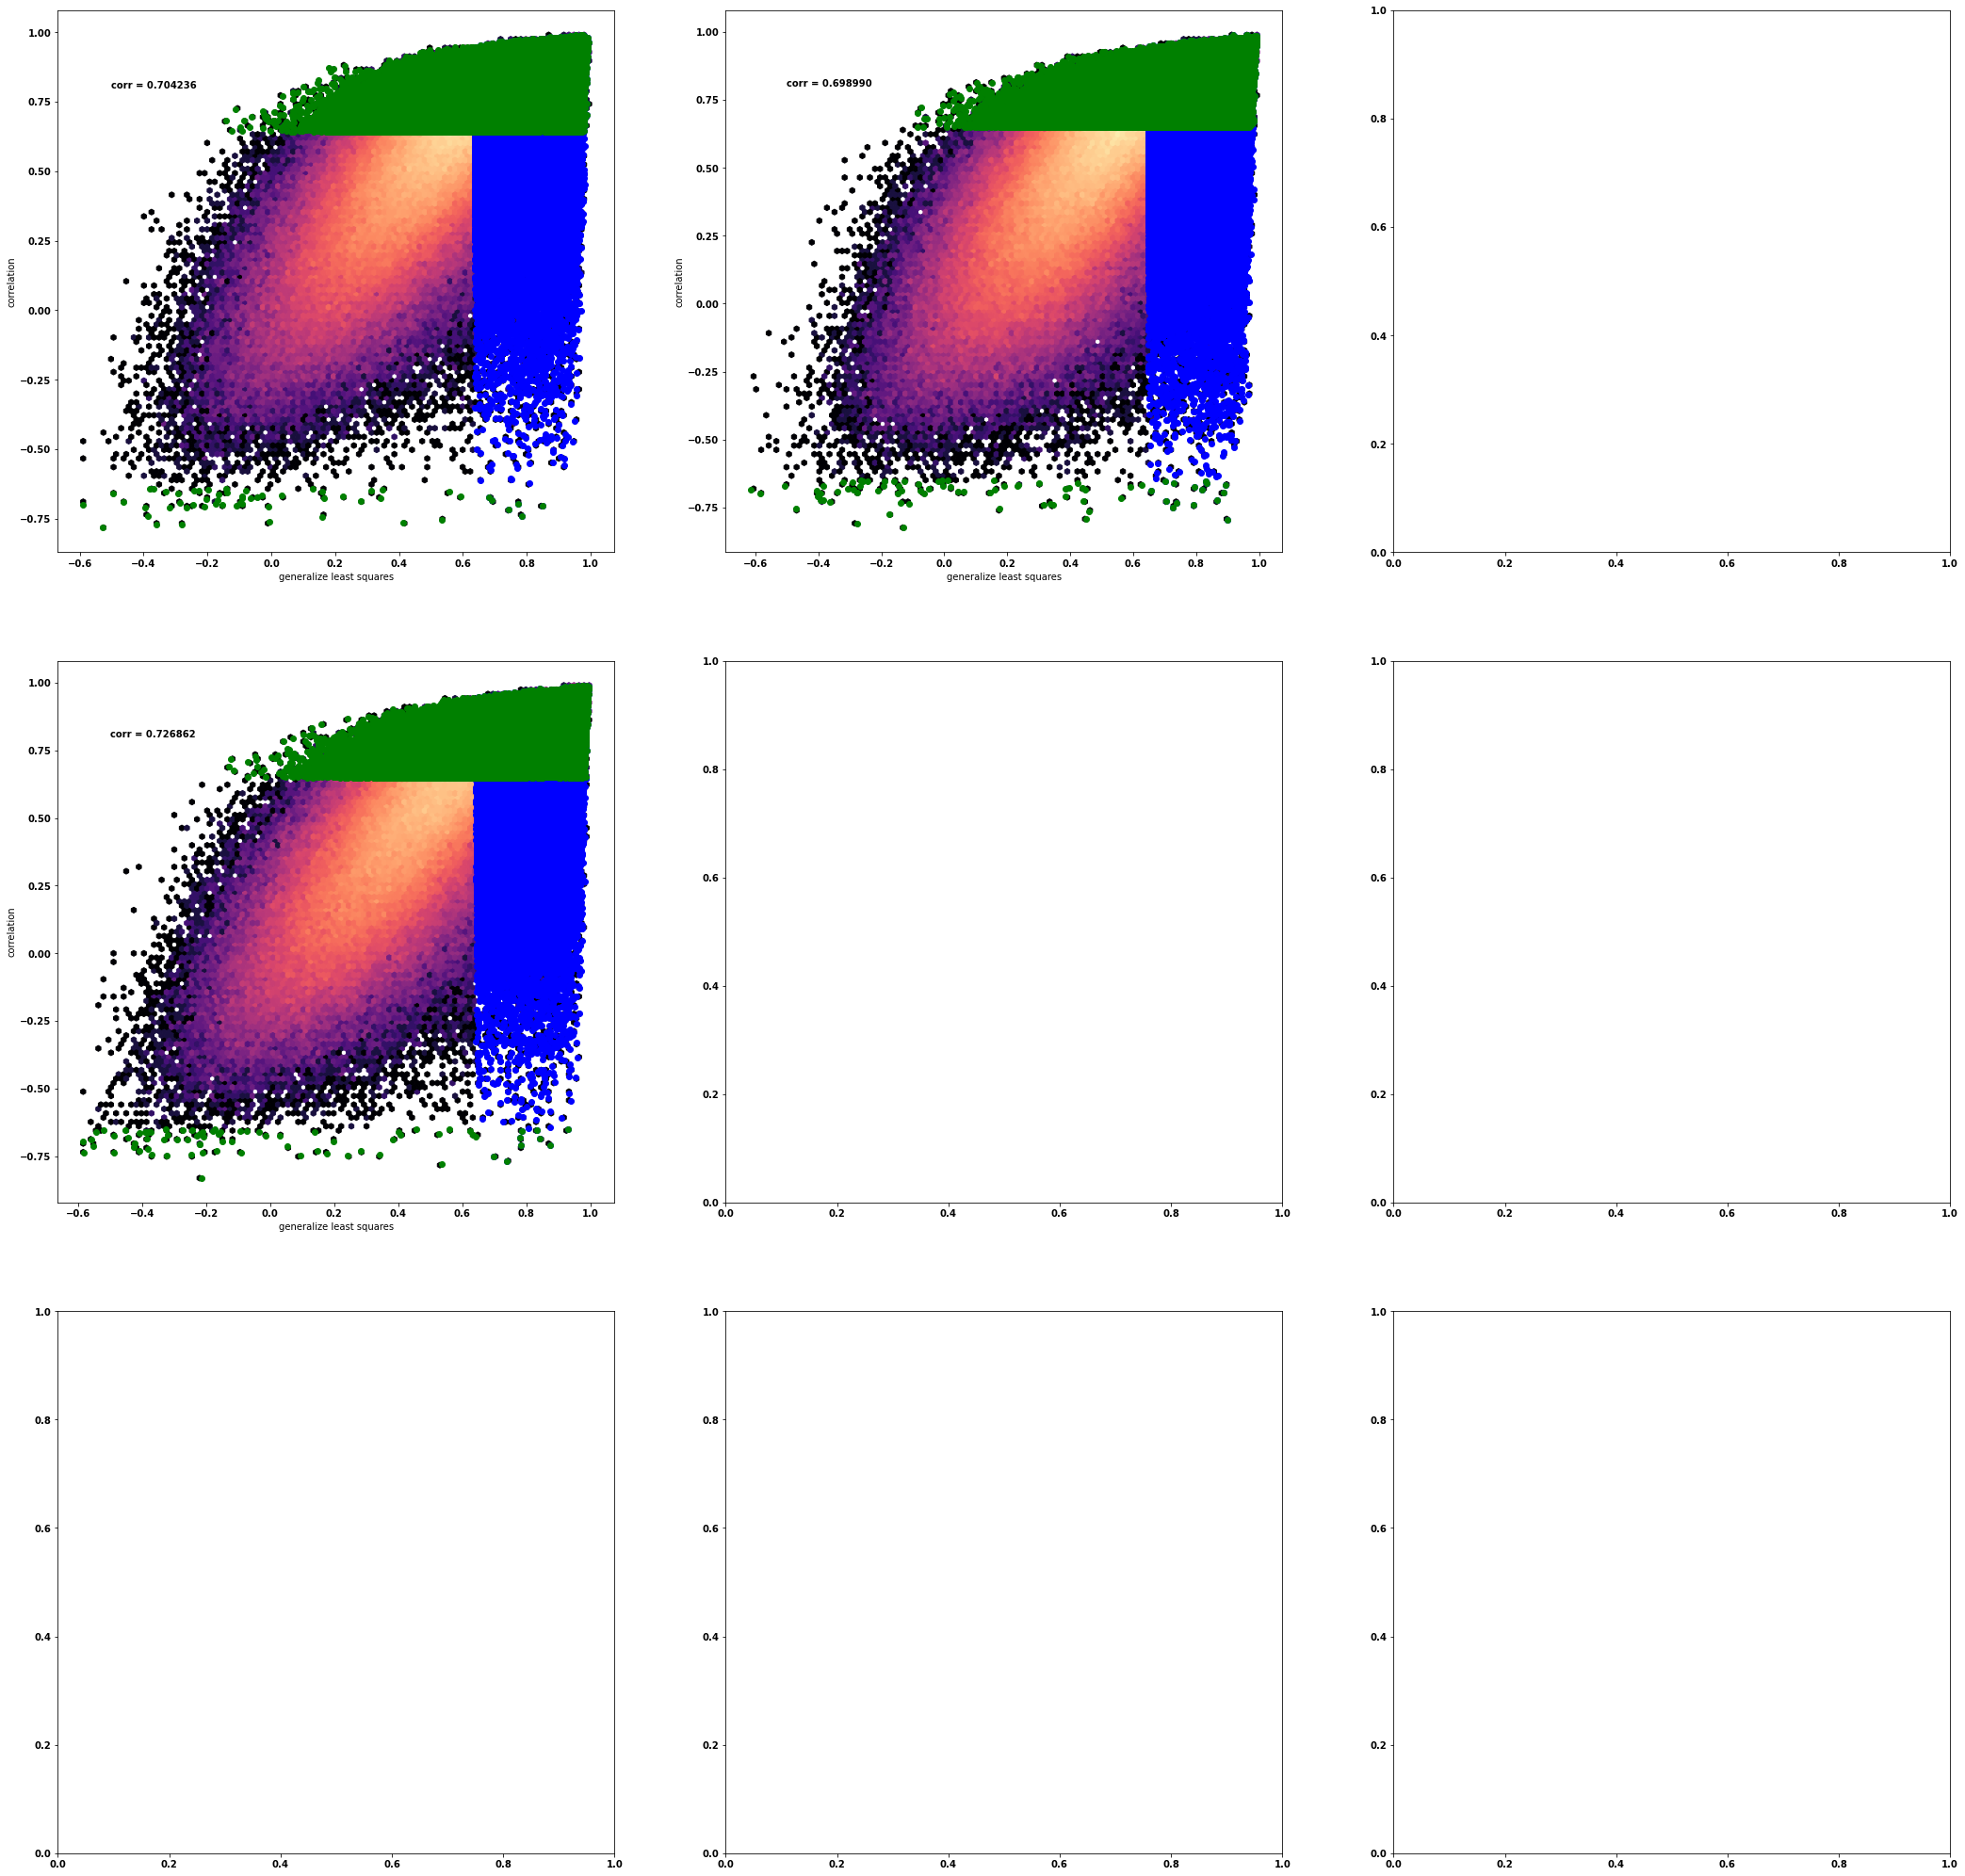

In [19]:
gene_gls = []
gene_corr = []
a_cons = []
p_cons = []

a_bg = []
p_bg = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    elif 'mouse' in pair:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/atac_gls_results/primate_conserved/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    x = np.sqrt(stats['r_square']) * np.sign(stats['coeff'])
    y = stats['pear_corr']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('generalize least squares')
    ax.set_ylabel('correlation')
    sig_gls = (stats['fdr']< .05) 
    sig_corr = (stats['fdr_pear'] < .05) 
    gene_gls.append(stats.loc[sig_gls]['human'].values)
    gene_corr.append(stats.loc[sig_corr]['human'].values)
    a_cons.append(stats.loc[stats['fdr'] < .05].human.values)
    a_bg.append(stats.human.values)
    if 'mouse' not in pair:
        p_cons.append(stats.loc[stats['fdr'] < .05].human.values)
        p_bg.append(stats.human.values)
    ax.text(-.5, .8, 'corr = {:4f}'.format(r))
    
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    print(pair)
    ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [20]:
def list_intersection(to_intersect):
    common = to_intersect[0]
    for item in to_intersect[1:]:
        common = np.intersect1d(common, item)
    return common

In [21]:
len(list_intersection(a_cons))

52947

In [22]:
stats.loc[stats['conserved_seq']=='primate']

,human,r_square,coeff,p_val,t_val,fdr,corr,fdr_corr,pear_corr,fdr_pear,mean_scaled_residual,conserved_seq
0,chr1-10001023-10001522,0.066390,0.321434,2.469943e-01,1.192573,1.000000,-0.057143,1.000000,0.011568,1.000000,0.728632,primate
1,chr1-100024376-100024875,0.018690,-0.211613,5.440710e-01,-0.617193,1.000000,0.025974,1.000000,-0.334876,1.000000,1.256369,primate
2,chr1-100035137-100035636,0.059309,0.254865,2.747679e-01,1.122928,1.000000,0.205195,1.000000,-0.022613,1.000000,0.511356,primate
5,chr1-100047319-100047818,0.009406,0.075416,6.676589e-01,0.435787,1.000000,-0.010390,1.000000,-0.083178,1.000000,1.155707,primate
6,chr1-100056545-100057044,0.210999,0.544337,3.150727e-02,2.312684,0.701494,0.236440,1.000000,0.215098,1.000000,0.318211,primate
...,...,...,...,...,...,...,...,...,...,...,...,...
265995,chrY-2841253-2841752,0.492716,0.752437,2.714584e-04,4.407449,0.014835,0.037662,1.000000,-0.033155,1.000000,0.273343,primate
265996,chrY-2867398-2867897,0.094316,0.337991,1.644511e-01,1.443179,1.000000,0.130562,1.000000,0.149646,1.000000,inf,primate
265997,chrY-2935036-2935535,0.776802,0.888116,6.056546e-08,8.343063,0.000013,0.564935,0.254126,0.688605,0.022034,0.144377,primate
265998,chrY-2935561-2936060,0.805007,1.012845,1.543921e-08,9.086676,0.000004,0.674026,0.040615,0.743844,0.005623,0.160479,primate


FileNotFoundError: [Errno 2] No such file or directory: '../../data/outputs/atac_gls_results/experimental/primate_conserved/gls_human_macaque.tsv'

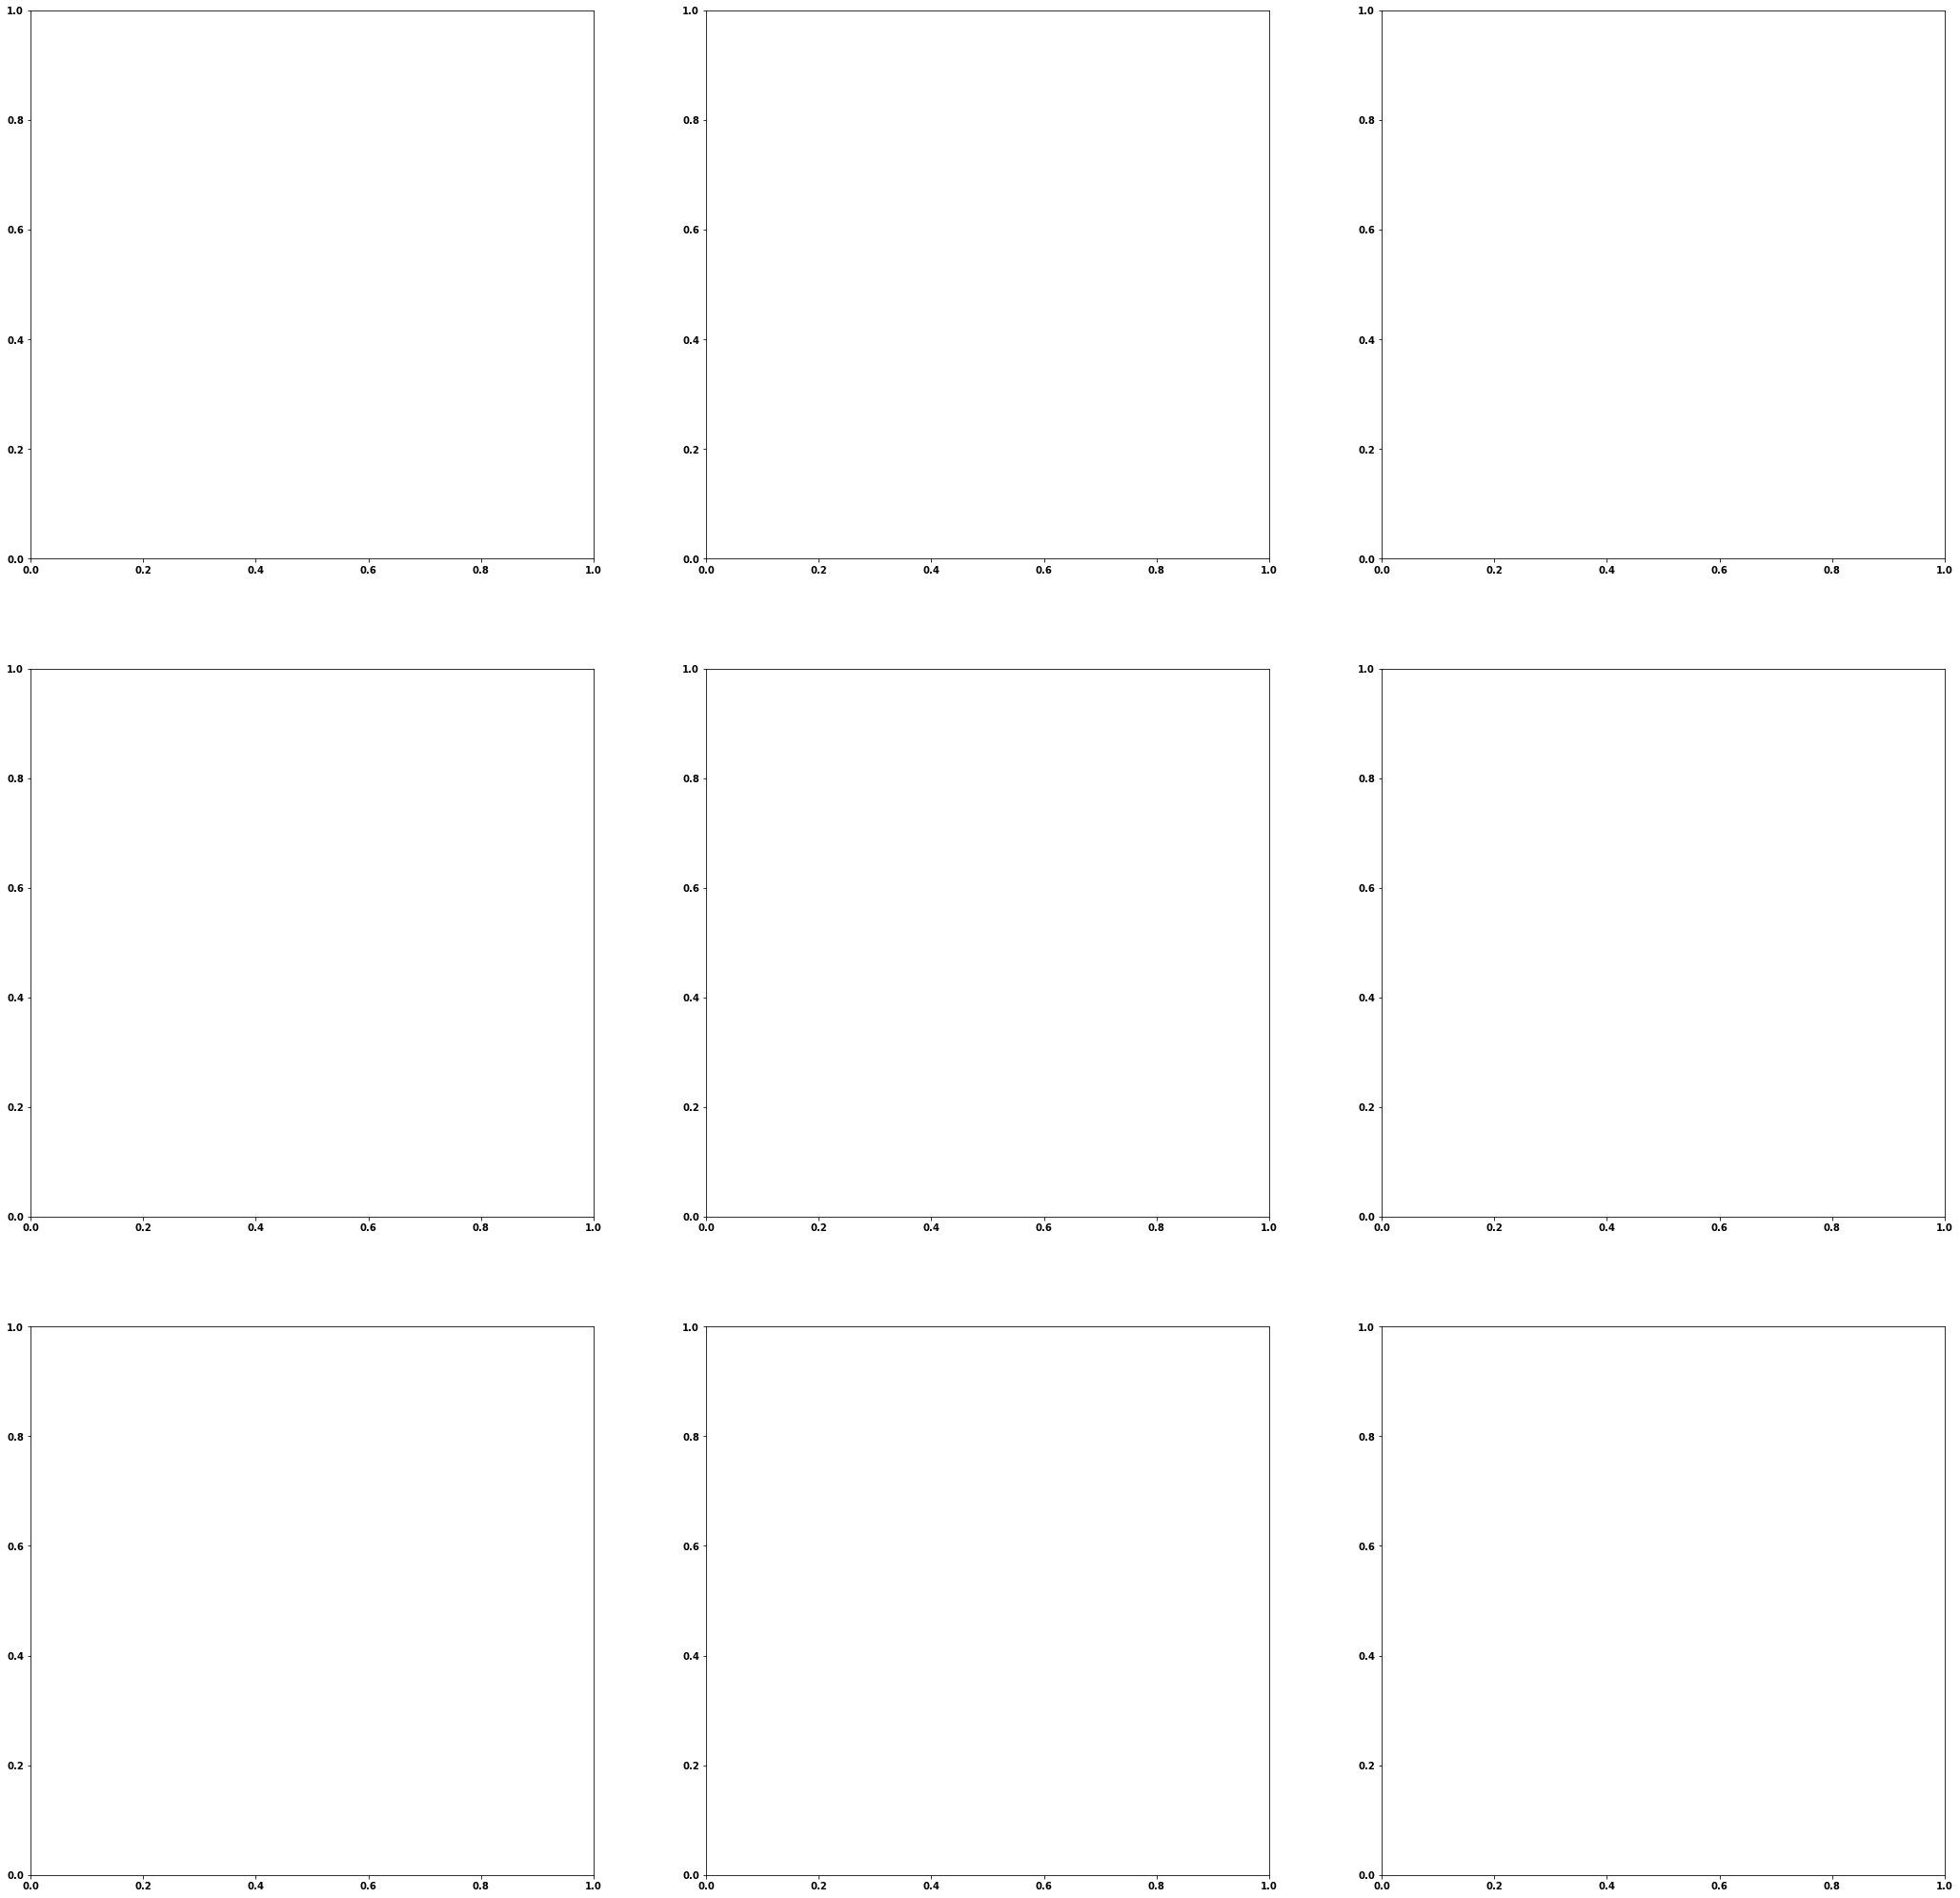

In [23]:
gene_gls = []
gene_corr = []
a_cons = []
p_cons = []

a_bg = []
p_bg = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    elif 'mouse' in pair:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/atac_gls_results/experimental/primate_conserved/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    x = np.sqrt(stats['r_square']) * np.sign(stats['coeff'])
    y = stats['pear_corr']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('generalize least squares')
    ax.set_ylabel('correlation')
    sig_gls = stats['fdr'] < .05
    sig_corr = stats['fdr_pear'] < .05
    gene_gls.append(stats.loc[sig_gls]['human'].values)
    gene_corr.append(stats.loc[sig_corr]['human'].values)
    a_cons.append(stats.loc[stats['fdr'] < .05].human.values)
    a_bg.append(stats.human.values)
    if 'mouse' not in pair:
        p_cons.append(stats.loc[stats['fdr'] < .05].human.values)
        p_bg.append(stats.human.values)
    ax.text(-.5, .8, 'corr = {:4f}'.format(r))
    
    primate = (stats['conserved_seq']=='primate').values
    mammal = (stats['conserved_seq']=='mammal').values
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    print(pair)
    ax.scatter(x[mammal], y[mammal], c='green')    
    ax.scatter(x[primate], y[primate], c='blue')    


In [ ]:
def list_intersection(to_intersect):
    common = to_intersect[0]
    for item in to_intersect[1:]:
        common = np.intersect1d(common, item)
    return common

In [ ]:
len(list_intersection(a_cons))

In [ ]:
def read_list(listfile):
    '''
    reads a newline separated list like created by save_list
    args:
        listfile: path to a textfile containing a newline separated list
    returns:
        a list of strings saved in the list file
    '''
    return open(listfile, 'r').read().strip('\n').split('\n')


In [ ]:
old_p = read_list('../../data/outputs/final/peaks/human_origin_primate_conserved.txt')
old_a = read_list('../../data/outputs/final/peaks/human_origin_all_conserved.txt')

In [ ]:
len(old_p)

In [ ]:
len(old_p) + len(old_a)

In [ ]:
len(list_intersection(p_cons))

In [ ]:
len(np.setdiff1d(list_intersection(p_cons), old_a))

In [ ]:
len(np.intersect1d(list_intersection(p_cons), old_a))

In [ ]:
len(old_a)

In [ ]:
len(old_a)

In [ ]:
high_cons = np.unique(np.concatenate(gene_gls))

In [ ]:
len(high_cons)

In [ ]:
len(np.setdiff1d(list_intersection(p_cons), list_intersection(a_cons)))

In [ ]:
pair_cons= np.setdiff1d(list_intersection(p_cons), high_cons)

In [ ]:
len(pair_cons)

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/experimental/relative_gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    x = np.sqrt(stats['r_square']) * np.sign(stats['coeff'])
    y = stats['corr']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('generalize least squares')
    ax.set_ylabel('correlation')
    sig_gls = stats['fdr'] < .05/2000
    sig_corr = stats['fdr_corr'] < .05/20
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    ax.text(-.5, .8, 'corr = {:4f}'.format(r))
    
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    ax.scatter(x[sig_corr], y[sig_corr], c='green')    

# examine models

In [ ]:
im = plt.imshow(corr_mat)
ticks = plt.yticks(np.arange(4), labels= species)
ticks = plt.xticks(np.arange(4), labels= species, rotation=90)
cbar = plt.colorbar(im)
cbar.set_label('% variance explained',
                       rotation=270,
                       labelpad=10)
plt.title('SLC17A7 similarity')

In [ ]:
im = plt.imshow(np.corrcoef(check.values.T))
ticks = plt.yticks(np.arange(4), labels= species)
ticks = plt.xticks(np.arange(4), labels= species, rotation=90)
cbar = plt.colorbar(im)
cbar.set_label('Pearson correlation',
                       rotation=270,
                       labelpad=10)
plt.title('SLC17A7 similarity')

In [ ]:
stats_z.loc[stats_z.t_val> 15]

In [ ]:
stats.loc[(stats_z.t_val> 10) & (stats.t_val < 10)]

In [ ]:
stats.loc[stats.human_gene == 'LHX6']

In [ ]:
stats_z.loc[stats.human_gene == 'LHX6']

In [ ]:
stats_z.loc[stats_z.fdr < .05/6].t_val.min()

In [ ]:
stats.loc[stats.fdr < .05/6].t_val.min()

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/relative/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    stats_z = pd.read_csv('../../data/outputs/gex_gls_results/relative/gls_z_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    
    # x = stats.t_val
    x = stats_z['t_val']
    y = stats['t_val']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('gls zscore')
    ax.set_ylabel('gls no z')
    sig_gls = (stats['fdr'] < .05/2000) & (stats['coeff'] > 0)
    sig_corr = stats['fdr_corr'] < .05
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    ax.text(10, 1, 'corr = {:4f}'.format(r))
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    # ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    # ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/relative/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    stats_z = pd.read_csv('../../data/outputs/gex_gls_results/relative/gls_z_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    
    # x = stats.t_val
    x = stats_z['pear_corr']
    y = stats['pear_corr']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('gls zscore')
    ax.set_ylabel('gls no z')
    sig_gls = (stats['fdr'] < .05/2000) & (stats['coeff'] > 0)
    sig_corr = stats['fdr_corr'] < .05
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    ax.text(10, 1, 'corr = {:4f}'.format(r))
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    # ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    # ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [ ]:
def list_intersection(to_intersect):
    '''
    get elements in the intersection of a group of lists/arrays
    
    args:
        to_intersect : a list of lists or other listlike objects
    returns:
        common : a numpy array of all elements common in all lists
    
    '''
    common = to_intersect[0]
    for item in to_intersect[1:]:
        common = np.intersect1d(common, item)
    return common

In [ ]:
primate = list_intersection(gene_gls[:3])

In [ ]:
primate_corr = list_intersection(gene_corr[:3])

In [ ]:
len(primate),len(primate_corr)

In [ ]:
len(list_intersection(gene_gls)), len(list_intersection(gene_corr))

In [ ]:
x = [i.loc[list_intersection(gene_gls)].mean(axis=1) for i in clust_measures.values()]

In [ ]:
y = [i.loc[~i.index.isin(list_intersection(gene_gls))].mean(axis=1) for i in clust_measures.values()]

In [ ]:
len(list_intersection(gene_gls)), len(list_intersection(gene_corr)) 

In [ ]:
list_intersection([list_intersection(gene_gls), list_intersection(gene_corr)])

In [ ]:
len(list_intersection([list_intersection(gene_gls), list_intersection(gene_corr)]))

In [ ]:
len(list_intersection(gene_gls))/10790 *  len(list_intersection(gene_corr))/10790

In [ ]:
plt.hexbin(stats['t_val'], stats['coeff'], bins='log', cmap='magma')